# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

Source: German Traffic Sign Dataset

In [1]:
%matplotlib inline

import numpy as np
import matplotlib
from matplotlib import pyplot
import tensorflow as tf

In [2]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:9999;
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

## Load The Data

In [3]:
# Load pickled data
import pickle
from pandas.io.parsers import read_csv

signnames = read_csv("signnames.csv").values[:,1]

training_file   = 'data/train.p'
validation_file = 'data/valid.p'
testing_file    = 'data/test.p'

def load_data(file):
    with open(file, mode='rb') as f:
        data = pickle.load(f)
        
    return data['features'], data['labels']

---

## Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**


In [4]:
X_train, y_train = load_data(training_file)
X_valid, y_valid = load_data(validation_file)
X_test, y_test   = load_data(testing_file)

n_train      = y_train.shape[0]
n_validation = y_valid.shape[0]
n_test       = y_test.shape[0]
image_shape  = X_train[0].shape

sign_classes, class_indices, class_counts = np.unique(y_train, return_index=True, return_counts=True)
n_classes = class_counts.shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory Visualization of the Dataset

Class 0: Speed limit (20km/h)                                180 samples


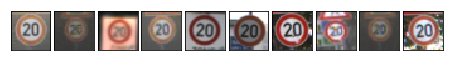

 -------------------------------------------------------------

Class 1: Speed limit (30km/h)                                1980 samples


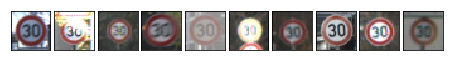

 -------------------------------------------------------------

Class 2: Speed limit (50km/h)                                2010 samples


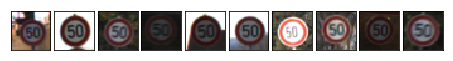

 -------------------------------------------------------------

Class 3: Speed limit (60km/h)                                1260 samples


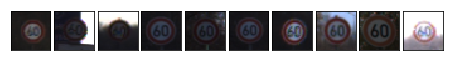

 -------------------------------------------------------------

Class 4: Speed limit (70km/h)                                1770 samples


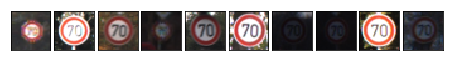

 -------------------------------------------------------------

Class 5: Speed limit (80km/h)                                1650 samples


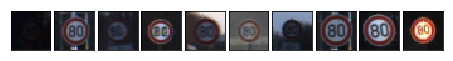

 -------------------------------------------------------------

Class 6: End of speed limit (80km/h)                         360 samples


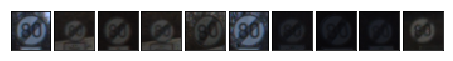

 -------------------------------------------------------------

Class 7: Speed limit (100km/h)                               1290 samples


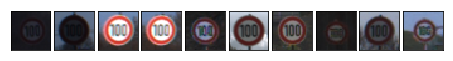

 -------------------------------------------------------------

Class 8: Speed limit (120km/h)                               1260 samples


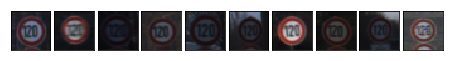

 -------------------------------------------------------------

Class 9: No passing                                          1320 samples


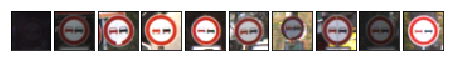

 -------------------------------------------------------------

Class 10: No passing for vehicles over 3.5 metric tons        1800 samples


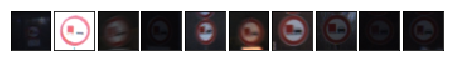

 -------------------------------------------------------------

Class 11: Right-of-way at the next intersection               1170 samples


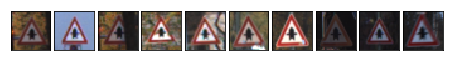

 -------------------------------------------------------------

Class 12: Priority road                                       1890 samples


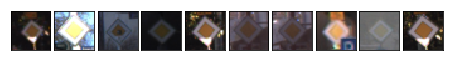

 -------------------------------------------------------------

Class 13: Yield                                               1920 samples


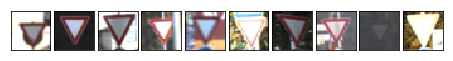

 -------------------------------------------------------------

Class 14: Stop                                                690 samples


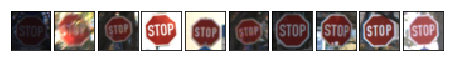

 -------------------------------------------------------------

Class 15: No vehicles                                         540 samples


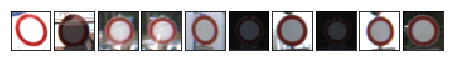

 -------------------------------------------------------------

Class 16: Vehicles over 3.5 metric tons prohibited            360 samples


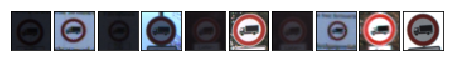

 -------------------------------------------------------------

Class 17: No entry                                            990 samples


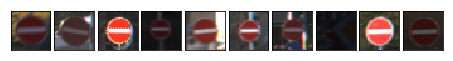

 -------------------------------------------------------------

Class 18: General caution                                     1080 samples


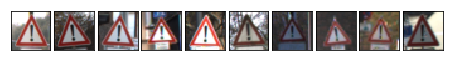

 -------------------------------------------------------------

Class 19: Dangerous curve to the left                         180 samples


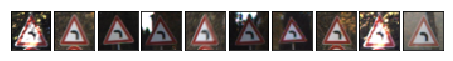

 -------------------------------------------------------------

Class 20: Dangerous curve to the right                        300 samples


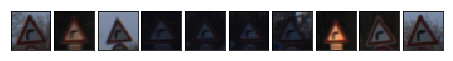

 -------------------------------------------------------------

Class 21: Double curve                                        270 samples


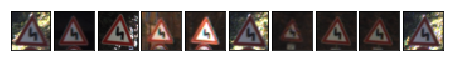

 -------------------------------------------------------------

Class 22: Bumpy road                                          330 samples


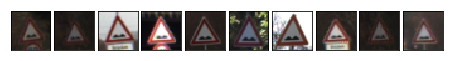

 -------------------------------------------------------------

Class 23: Slippery road                                       450 samples


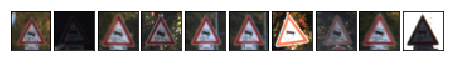

 -------------------------------------------------------------

Class 24: Road narrows on the right                           240 samples


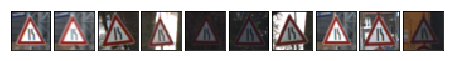

 -------------------------------------------------------------

Class 25: Road work                                           1350 samples


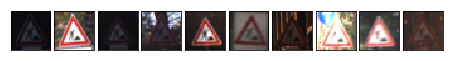

 -------------------------------------------------------------

Class 26: Traffic signals                                     540 samples


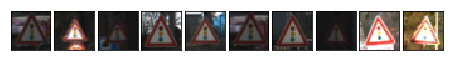

 -------------------------------------------------------------

Class 27: Pedestrians                                         210 samples


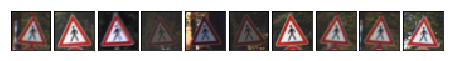

 -------------------------------------------------------------

Class 28: Children crossing                                   480 samples


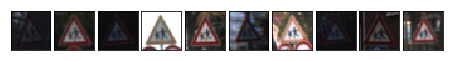

 -------------------------------------------------------------

Class 29: Bicycles crossing                                   240 samples


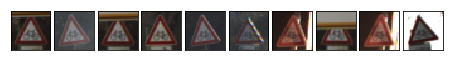

 -------------------------------------------------------------

Class 30: Beware of ice/snow                                  390 samples


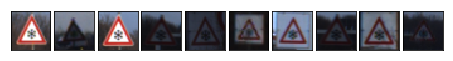

 -------------------------------------------------------------

Class 31: Wild animals crossing                               690 samples


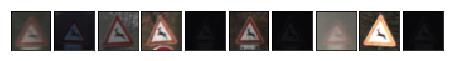

 -------------------------------------------------------------

Class 32: End of all speed and passing limits                 210 samples


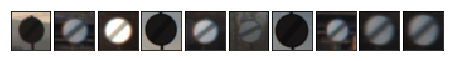

 -------------------------------------------------------------

Class 33: Turn right ahead                                    599 samples


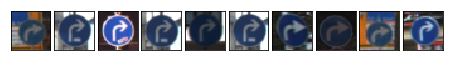

 -------------------------------------------------------------

Class 34: Turn left ahead                                     360 samples


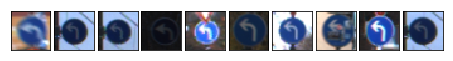

 -------------------------------------------------------------

Class 35: Ahead only                                          1080 samples


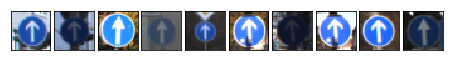

 -------------------------------------------------------------

Class 36: Go straight or right                                330 samples


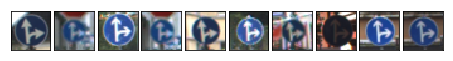

 -------------------------------------------------------------

Class 37: Go straight or left                                 180 samples


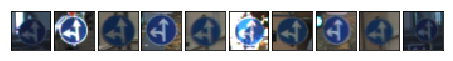

 -------------------------------------------------------------

Class 38: Keep right                                          1860 samples


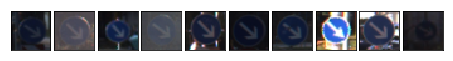

 -------------------------------------------------------------

Class 39: Keep left                                           270 samples


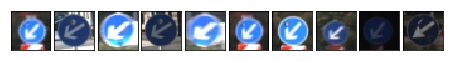

 -------------------------------------------------------------

Class 40: Roundabout mandatory                                300 samples


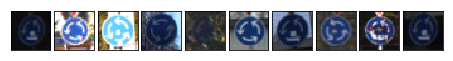

 -------------------------------------------------------------

Class 41: End of no passing                                   210 samples


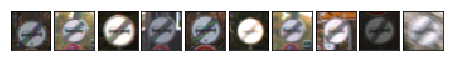

 -------------------------------------------------------------

Class 42: End of no passing by vehicles over 3.5 metric tons  210 samples


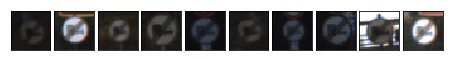

 -------------------------------------------------------------



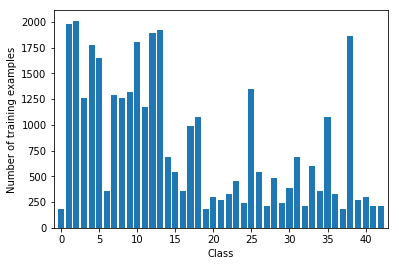

In [5]:
import random

column_width = max(len(name) for name in signnames)

for c, c_index, c_count in zip(sign_classes, class_indices, class_counts):
    print("Class %i: %-*s  %s samples" % (c, column_width, signnames[c], str(c_count)))
    fig = pyplot.figure(figsize = (6, 1))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.1, wspace = 0.1)
    random_indices = random.sample(range(c_index, c_index + c_count), 10)
    for i in range(10):
        axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
        axis.imshow(X_train[random_indices[i]])
    pyplot.show()
    print(" -------------------------------------------------------------\n")
    
pyplot.bar(np.arange(43), class_counts, align='center')
pyplot.xlabel('Class')
pyplot.ylabel('Number of training examples')
pyplot.xlim([-1, 43])
pyplot.show()


Overall data volume is less than ideal with some classes with only 180 examples.
This will certently affect the ability of the model to generalise.

One simple solution to our lack of data is to flip signs that are symmetrical in at least one the panes, thus giving us more samples in these classes, for example `Class 40: Roundabout mandatory` or `Class 35: Ahead only`.

Other signs are complementary in nature, like `Class 33: Turn right ahead` and `Class 34: Turn left ahead`, these could be flipped and added to the complementary class.

In [6]:
training_file   = 'data/train.p'
validation_file = 'data/valid.p'
testing_file    = 'data/test.p'

training_augmented_file   = 'data/train_augmented.p'
validation_augmented_file = 'data/valid_augmented.p'
testing_augmented_file    = 'data/test_augmented.p'

----

## Design and  Model Architecture

### LeNet
<img src="architecture.png">
Source: Yan LeCun

I've decided to use the LeNet-5 architecture. It accepts a 32x32xC image as input, where C is the number of color channels. 

### Data Pre-processing 

Images are mormalized so that the data as mean zero and equal variance.

Images are also converted to grayscale.

In [7]:
import sys
import time

def print_progress(iteration, total):
    """
    Call in a loop to create terminal progress bar
    
    Parameters
    ----------
    iteration :  Current iteration (Int)
    total     :  Total iterations (Int)
    """
    str_format = "{0:.0f}"
    percents = str_format.format(100 * (iteration / float(total)))
    filled_length = int(round(100 * iteration / float(total)))
    bar = '█' * filled_length + '-' * (100 - filled_length)

    sys.stdout.write('\r |%s| %s%%' % (bar, percents)),

    if iteration == total:
        sys.stdout.write('\n')
    sys.stdout.flush()

In [8]:
from sklearn.utils import shuffle
from skimage import exposure
import warnings 

try:
    n_classes
except NameError:
    n_classes = 43

def preprocess_data(X, y = None):
    """
    Performs:
    ---------
    Conversion to  grayscale
    feature scaling 
    Assumes original data is sorted by labels.
    
    Parameters
    ----------
    X: ndarray
       Data array containing feature examples.
    y: ndarray, optional, defaults to `None`
       Data labels in index form.
       
    Returns
    -------
    A tuple of X and y.    
    """
    print("Preprocessing data with {} examples:".format(X.shape[0]))

    # Convert to grayscale
    X = 0.299 * X[:, :, :, 0] + 0.587 * X[:, :, :, 1] + 0.114 * X[:, :, :, 2]
    
    # Normalizes the data
    X = (X / 255.).astype(np.float32)
        
    for i in range(X.shape[0]):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            X[i] = exposure.equalize_adapthist(X[i])
        print_progress(i + 1, X.shape[0])
        
    # Adds a single grayscale channel
    X = X.reshape(X.shape + (1,)) 
    return X, y

def class_name(one_hot):
    return signnames[one_hot.nonzero()[0][0]]

def load_and_preprocess_data(dat_file):
    x, y = load_data(dat_file)
    x, y = preprocess_data(x, y)
    return (x, y)

### Load the Data

In [9]:
training_file   = 'data/train.p'
validation_file = 'data/valid.p'
testing_file    = 'data/test.p'

X_train, y_train = load_and_preprocess_data(training_file)
X_valid, y_valid = load_and_preprocess_data(validation_file)
X_test,  y_test  = load_and_preprocess_data(testing_file)

Preprocessing data with 34799 examples:
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100%
Preprocessing data with 4410 examples:
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100%
Preprocessing data with 12630 examples:
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100%


### Model Architecture

In [10]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

EPOCHS     = 25
BATCH_SIZE = 256
DEPTH      = 1

def leNet(x):
    # Hyperparameters
    mu    = 0
    sigma = 0.1
    
    # Layer 1: 
    # Convolutional, Input: 32x32x1, Output: 28x28x6
    conv1_w = tf.Variable(tf.truncated_normal(shape=(5,5,DEPTH,6), mean=mu, stddev=sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_w, strides=[1,1,1,1], padding='VALID') + conv1_b
    # Activation
    conv1   = tf.nn.relu(conv1)
    # Pooling: Input: 28x28x6, Output: 14x14x6
    conv1   = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    # Layer 2: 
    # Convolutional, Input: 14x14x6, Output: 10x10x16
    conv2_w = tf.Variable(tf.truncated_normal(shape=(5,5,6,16), mean=mu, stddev=sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_w, strides=[1,1,1,1], padding='VALID') + conv2_b
    # Activation
    conv2   = tf.nn.relu(conv2)
    # Pooling: Input: 28x28x6, Output: 14x14x6
    conv2   = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    # Flatten: Input: 10x10x16, Output: 5x5x16
    fc0 = flatten(conv2)
    
    # Layer 3:
    # Fully Connected, Input: 400, Output: 120
    fc1_w = tf.Variable(tf.truncated_normal(shape=(400, 120), mean=mu, stddev=sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_w) + fc1_b
    # Activation
    fc1   = tf.nn.relu(fc1)
    
    # Layer 4:
    # Fully Connected, Input: 120, Output: 84
    fc2_w = tf.Variable(tf.truncated_normal(shape=(120, 84), mean=mu, stddev=sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2   = tf.matmul(fc1, fc2_w) + fc2_b
    # Activation
    fc2   = tf.nn.relu(fc2)
    
    # Layer 5:
    # Fully Connected, Input: 84, Output: 43
    fc3_w  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean=mu, stddev=sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_w) + fc3_b
    
    return logits

### Train, Validate and Test the Model

#### Features and Labels

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [11]:
x = tf.placeholder(tf.float32, (None, 32, 32, DEPTH))
y = tf.placeholder(tf.int32, (None))

one_hot_y = tf.one_hot(y, 43)

#### Training Pipeline

In [12]:
learning_rate = 0.0015

logits = leNet(x)

cross_entropy      = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation     = tf.reduce_mean(cross_entropy)
optimizer          = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_operation = optimizer.minimize(loss_operation)

#### Model Evaluation

In [13]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) 

def evaluate(x_data, y_data):
    num_examples   = len(x_data)
    total_accuracy = 0
    sess           = tf.get_default_session()
    
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = x_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    
    return total_accuracy / num_examples

#### Train the Model

In [14]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCHS {} ...".format(i+1))
        print("Validation accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    saver.save(sess, 'lenet')
    print("Model saved.")

Training...

EPOCHS 1 ...
Validation accuracy = 0.733

EPOCHS 2 ...
Validation accuracy = 0.844

EPOCHS 3 ...
Validation accuracy = 0.875

EPOCHS 4 ...
Validation accuracy = 0.892

EPOCHS 5 ...
Validation accuracy = 0.904

EPOCHS 6 ...
Validation accuracy = 0.927

EPOCHS 7 ...
Validation accuracy = 0.933

EPOCHS 8 ...
Validation accuracy = 0.945

EPOCHS 9 ...
Validation accuracy = 0.937

EPOCHS 10 ...
Validation accuracy = 0.941

EPOCHS 11 ...
Validation accuracy = 0.940

EPOCHS 12 ...
Validation accuracy = 0.935

EPOCHS 13 ...
Validation accuracy = 0.933

EPOCHS 14 ...
Validation accuracy = 0.939

EPOCHS 15 ...
Validation accuracy = 0.943

EPOCHS 16 ...
Validation accuracy = 0.947

EPOCHS 17 ...
Validation accuracy = 0.944

EPOCHS 18 ...
Validation accuracy = 0.945

EPOCHS 19 ...
Validation accuracy = 0.944

EPOCHS 20 ...
Validation accuracy = 0.946

EPOCHS 21 ...
Validation accuracy = 0.944

EPOCHS 22 ...
Validation accuracy = 0.949

EPOCHS 23 ...
Validation accuracy = 0.946

EPOCHS 

#### Evaluate the Model

In [15]:

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.925


---

## Step 3: Test a Model on New Images

We'll now test the model on images from the web.

5 images were downloaded from the web, a quick google search for German traffic signs, and saved to be analysed.

### Load and Output the Images

In [16]:
def top_k_predictions(X, k = 5):
    """
    Parameters
    ----------
    X : Testing dataset. 
    k : Number of top predictions we are interested in.
              
    Returns
    -------
    """
    tf_x = tf.placeholder(tf.float32, shape = (None, 32, 32, 1))

    predictions = tf.nn.softmax(leNet(tf_x))
    top_k_predictions = tf.nn.top_k(predictions, k)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, tf.train.latest_checkpoint('.'))
        p = sess.run(top_k_predictions, feed_dict = {tf_x: X})
        return np.array(p)


In [17]:
from skimage import io
import matplotlib.gridspec as gridspec
import os

def load_web_image(image_i):
    """
    Parameters
    ----------
    image_i: web image index
    
    Returns
    -------
    ndarray of the image
    """
    return io.imread(os.getcwd() + '/data/web/{}.jpeg'.format(image_i))

def plot_image_statistics(predictions, index):
    """
    Plots prediction statistics for a single example.

    Parameters
    ----------
    predictions   : Array of predictions.
    index         : Index of the example we need to plot statistics for
    """
    # Prepare original and preprocessed images
    original = load_web_image(index + 1)
    preprocessed = X_custom[index].reshape(32, 32)
        
    # Prepare the grid
    pyplot.figure(figsize = (6, 2))
    gridspec.GridSpec(2, 2)
    
    # Plot original image
    pyplot.subplot2grid((2, 2), (0, 0), colspan=1, rowspan=1)
    pyplot.imshow(original)
    pyplot.axis('off')

    # Plot preprocessed image
    pyplot.subplot2grid((2, 2), (1, 0), colspan=1, rowspan=1)
    pyplot.imshow(preprocessed, cmap='gray')
    pyplot.axis('off')

    # Plot predictions    
    pos = np.arange(5)+.5 # the bar centers on the y axis
    pyplot.subplot2grid((2, 2), (0, 1), colspan=1, rowspan=2)
    pyplot.barh(np.arange(5)+.5, predictions[0][index], align='center')
    pyplot.yticks(pos, signnames[predictions[1][index].astype(int)])
    pyplot.xlabel('Probability')
    pyplot.tick_params(axis='both', which='both', 
                       labelleft='off', labelright='on', 
                       labeltop='off', labelbottom='on')
    
    pyplot.show()

num_web_images = 5

# Load images from .jpeg files to `X_custom` NumPy array
X_custom = np.empty([0, 32, 32, 3], dtype = np.int32)
for i in range(num_web_images):
    image = load_web_image(i + 1)
    X_custom = np.append(X_custom, [image[:, :, :3]], axis = 0)

# Actual classes of the images    
y_custom = np.array([
    28, # "1"
    14, # "2"
    3,  # "3"
    18, # "4"
    38, # "5"
])

# Preprocess and get predictions based on the current model
X_custom, _ = preprocess_data(X_custom)
predictions = top_k_predictions(X_custom)

Preprocessing data with 5 examples:
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100%


### Predict the Sign Type for Each Image

Actual class:  Children crossing


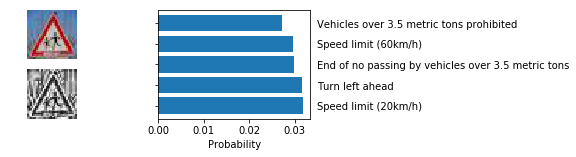

--------------------------------------------------------------------------

Actual class:  Stop


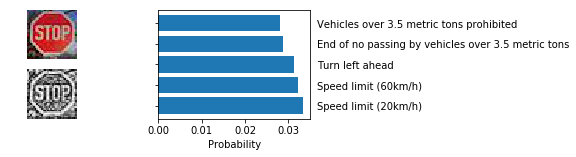

--------------------------------------------------------------------------

Actual class:  Speed limit (60km/h)


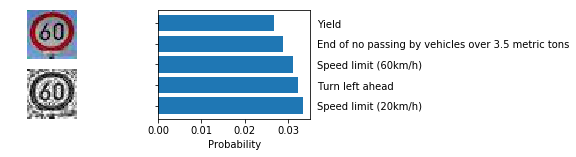

--------------------------------------------------------------------------

Actual class:  General caution


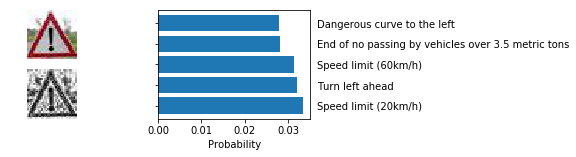

--------------------------------------------------------------------------

Actual class:  Keep right


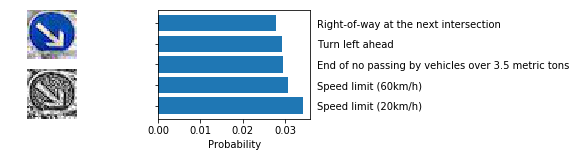

--------------------------------------------------------------------------



In [18]:
for i in range(num_web_images):
    print("Actual class: ", signnames[y_custom[i]] if y_custom[i] != 99 else "None")
    plot_image_statistics(predictions, i)
    print("--------------------------------------------------------------------------\n")

The model did **not** accurately predict any of the images download from the web, this is most likely a bug in the code that runs the web images through the model as the model trained and tested well, over **93%**.